# Purpose

Of this notebook is to create a new demo video from an actual in-store footage.

In [484]:
import os

%matplotlib notebook
import matplotlib.pyplot as plt

from IPython.display import Image, display

### Original Video

In [485]:
DATA_DIR = 'data_for_demo_v2'
VENDNET_VIDEOS_DIR = 'vendnet'
VENDGAZE_VIDEOS_DIR = 'gaze'

# ORIGINAL_VIDEO_FILENAME = 'shoppers-demo.mp4'
FACE_DETECTION_VIDEO_FILENAME = 'output-None.avi'
GAZE_DETECTION_VIDEO_FILENAME = 'output-test.avi'

FACE_BBOXES_FILENAME = 'video-det-fold-None.txt'
GAZE_ANGLES_FILENAME = 'output-test.txt'

ORIGINAL_VIDEO_PATH = os.path.join('..', 'data', ORIGINAL_VIDEO_FILENAME)
FACE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VENDNET_VIDEOS_DIR, FACE_DETECTION_VIDEO_FILENAME)
GAZE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VENDGAZE_VIDEOS_DIR, GAZE_DETECTION_VIDEO_FILENAME)
FACE_BBOXES_PATH = os.path.join(DATA_DIR, VENDNET_VIDEOS_DIR, FACE_BBOXES_FILENAME)
GAZE_ANGLES_PATH = os.path.join(DATA_DIR, VENDGAZE_VIDEOS_DIR, GAZE_ANGLES_FILENAME)

In [486]:
from moviepy.editor import *

In [487]:
# gaze_video = VideoFileClip(GAZE_DETECTION_VIDEO_PATH)
# gaze_video.ipython_display(width=500)

### Visualize Gaze

In [488]:
import pandas as pd
import numpy as np

In [489]:
bbox_df = pd.read_csv(FACE_BBOXES_PATH, delimiter='\t', header=None)
bbox_df.columns = ['frame_number', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence_score']

In [490]:
len(bbox_df)

80610

In [491]:
bbox_df.head()

,frame_number,x_min,y_min,x_max,y_max,confidence_score
0,1,502.57535,112.825874,674.53030,354.98624,0.999960
1,1,389.60460,230.601670,405.47437,248.05019,0.838076
2,1,409.85602,260.307400,422.62750,274.13644,0.436062
3,1,253.61615,81.434990,262.67172,94.39280,0.329670
4,1,244.22772,86.119980,254.19780,97.91320,0.125964


In [492]:
gaze_df = pd.read_csv(GAZE_ANGLES_PATH, delimiter=' ', header=None)
gaze_df.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle', 'x_center', 'y_center']

In [493]:
len(gaze_df)

80610

In [494]:
gaze_df.tail()

,frame_number,x_angle,y_angle,z_angle,x_center,y_center
80605,11190,NaN,NaN,NaN,NaN,NaN
80606,11190,NaN,NaN,NaN,NaN,NaN
80607,11190,NaN,NaN,NaN,NaN,NaN
80608,11190,NaN,NaN,NaN,NaN,NaN
80609,11190,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


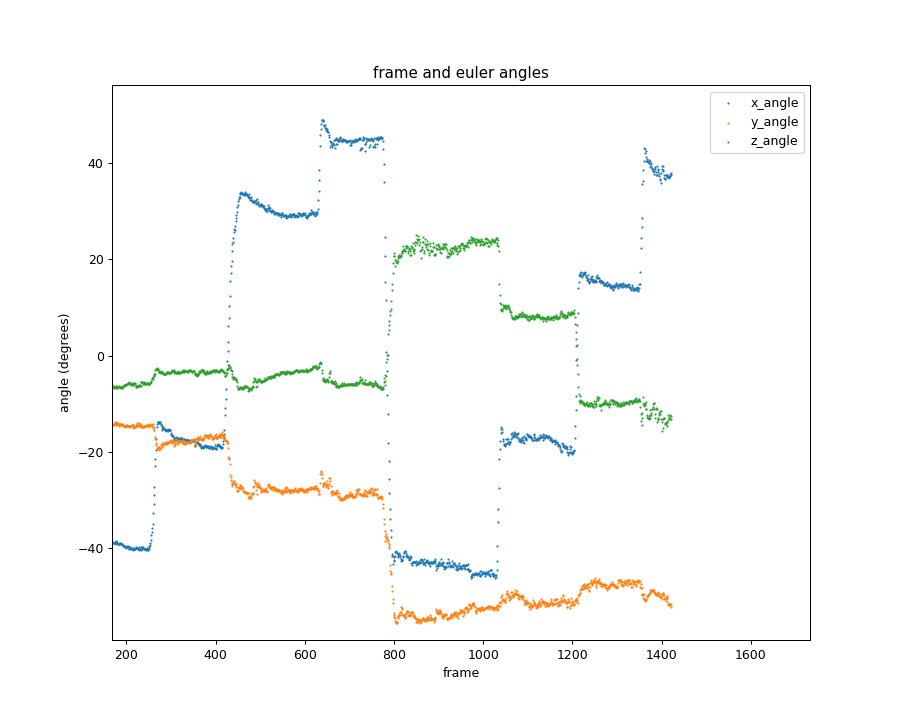

In [498]:
MARKER_SIZE = 0.5
FRAME_LIMIT = 12000

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

x = gaze_df.T.loc['frame_number'][:FRAME_LIMIT]
ax1.scatter(x, gaze_df.T.loc['x_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # x angle
ax1.scatter(x, gaze_df.T.loc['y_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # y angle
ax1.scatter(x, gaze_df.T.loc['z_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # z angle

plt.title("frame and euler angles")
plt.xlabel("frame")
plt.ylabel("angle (degrees)")
# plt.xticks(np.arange(0, FRAME_LIMIT, step=100))

plt.legend(["x_angle", "y_angle", "z_angle"])
fig.show()

In [499]:
TIME_MARKERS_SEC = [4, 12, 20, 28, 35, 45, 53, 58]
TIME_MARKERS_FRAMES = [(24 * i) for i in TIME_MARKERS_SEC]

In [500]:
TIME_MARKERS_FRAMES

[96, 288, 480, 672, 840, 1080, 1272, 1392]

In [501]:
def calculate_rectangle_centroid(min_x, min_y, max_x, max_y):
    """
    Returns a tuple (x, y) which gives the position of the face bounding box.
    """
    return (min_x + max_x) / 2, (min_y + max_y) / 2  


def calculate_rectangle_area(min_x, min_y, max_x, max_y):
    """
    Returns the pixel area of the face bounding box.
    """
    return (max_x - min_x) * (max_y - min_y)

rect_centroids = []
rect_areas = []
gaze_x_angles = []
gaze_y_angles = []
gaze_z_angles = []

MAX_PADDING = 20

for frame in TIME_MARKERS_FRAMES:
    error = True
    print("frame", frame)
    
    # bbox
    # TODO: Take the average over the variance-bound frame interval
    bbox_coords = bbox_df.loc[bbox_df["frame_number"] == frame][['x_min', 'y_min', 'x_max', 'y_max']].as_matrix()[0]
    rect_centroid = calculate_rectangle_centroid(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])
    rect_area = calculate_rectangle_area(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])
    
    # gaze
    def get_average(angle, max_padding):
        padding = 1
        
        before = frame - padding <= gaze_df["frame_number"]
        after = gaze_df["frame_number"] <= frame + padding
        a = gaze_df.loc[after & before][angle].values
        
        # Variance-bound dynamic padding increments
        while a.var() <= 2.5 and padding < MAX_PADDING: # max variance setting
            padding += 1
            before = frame - padding <= gaze_df["frame_number"]
            after = gaze_df["frame_number"] <= frame + padding
            a = gaze_df.loc[after & before][angle].values
#             print(a.mean(), a.var())
        
        print("final padding:", padding)
        return a.mean()
    
    gaze_x_angle = get_average('x_angle', MAX_PADDING)
    gaze_y_angle = get_average('y_angle', MAX_PADDING)
    gaze_z_angle = get_average('z_angle', MAX_PADDING)
    #gaze_x_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['x_angle'].values[0]
    #gaze_y_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['y_angle'].values[0]
    #gaze_z_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['z_angle'].values[0]
    
    rect_centroids.append(rect_centroid)
    rect_areas.append(rect_area)
    gaze_x_angles.append(gaze_x_angle)
    gaze_y_angles.append(gaze_y_angle)
    gaze_z_angles.append(gaze_z_angle)
    
    print("rect_centroid", rect_centroid)
    print("rect_area", rect_area)
    print("gaze_angles", gaze_x_angle, gaze_y_angle, gaze_z_angle)
    print()

frame 96
final padding: 1
final padding: 1
final padding: 1
rect_centroid (620.5976499999999, 227.540865)
rect_area 37784.392783945004
gaze_angles nan nan nan

frame 288
final padding: 1
final padding: 1
final padding: 1
rect_centroid (603.9273400000001, 233.81351999999998)
rect_area 38980.28660651999
gaze_angles nan nan nan

frame 480
final padding: 1
final padding: 1
final padding: 1
rect_centroid (546.95553, 226.642445)
rect_area 36225.78664391818
gaze_angles nan nan nan

frame 672
final padding: 1
final padding: 1
final padding: 1
rect_centroid (548.92312, 242.74955)
rect_area 35284.00380444
gaze_angles nan nan nan

frame 840
final padding: 1
final padding: 1
final padding: 1
rect_centroid (684.527, 303.67912)
rect_area 29089.580147919994
gaze_angles nan nan nan

frame 1080
final padding: 1
final padding: 1
final padding: 1
rect_centroid (636.733095, 304.87568)
rect_area 25574.49392124359
gaze_angles nan nan nan

frame 1272
final padding: 1
final padding: 1
final padding: 1
rect_ce

In [502]:
# creating the shelf plane

# can define shelf plane with just the point (rect_centroid) 
# and normal vector (to be calculated)

# then the distance of the shelves from the person with some estimate
# to move that plane in the direction of the norm vector

# IOPOTS (Index of product orthogonal to shelf) 
IOPOTS = 0

print(gaze_x_angles[IOPOTS], gaze_y_angles[IOPOTS], gaze_z_angles[IOPOTS])
yaw_angle = gaze_x_angles[IOPOTS]
pitch_angle = gaze_y_angles[IOPOTS]

DIST_ESTIMATE = 100000

nan nan nan


In [503]:
def convert_from_euler_angle_to_vector(yaw_angle, pitch_angle):
    """
    Converts from angles to directional vector.
    """
    yaw_angle_radians = yaw_angle * np.pi / 180
    pitch_angle_radians = pitch_angle * np.pi / 180
    
    return np.array([
        np.cos(yaw_angle_radians) * np.cos(pitch_angle_radians),
        np.sin(yaw_angle_radians) * np.cos(pitch_angle_radians),
        np.sin(pitch_angle_radians)
    ])

In [504]:
# what does the vector look like?
def plot_directional_vectors(z_vectors):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5, 5))
    
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-1, 2)
    ax.set_ylim3d(-1, 2)
    ax.set_zlim3d(-1, 2)
#     ax.hold(True)
    
    for z_vector in z_vectors:
        print(z_vector)
        ax.quiver(0, 0, 0, *z_vector, length = 5)

    plt.show()

In [505]:
z_vectors = []
for yaw, pitch in zip(gaze_x_angles, gaze_y_angles):
    z_vector = convert_from_euler_angle_to_vector(yaw, pitch)    
    z_vectors.append(z_vector)

<IPython.core.display.Javascript object>


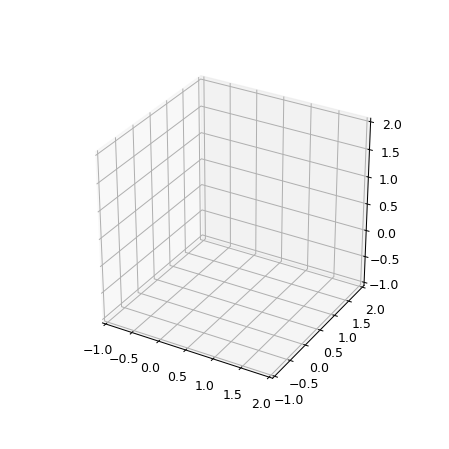

[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]


In [506]:
plot_directional_vectors(z_vectors)

In [474]:
z_vectors[IOPOTS]

array([ 0.76281523, -0.59050583, -0.26346875])

In [473]:
shelf_plane_norm = z_vectors[IOPOTS]

In [475]:
def calculate_poi_new(n_vector, i_vector, dist_estimate):
    """
    Finds the point of intersection of a vector on the shelf plane.
    
    n_vector is shelf plane vector i.e. normal to the shelf plane
    i_vector is intersecting vector
    dist_estimate is estimate of shelf distance from person
    
    Notation from http://www.ambrsoft.com/TrigoCalc/Plan3D/PlaneLineIntersection_.htm
    """
    p_vector = n_vector + dist_estimate
    t = -(np.dot(n_vector, p_vector) + dist_estimate) / float(np.dot(n_vector, i_vector))  
    return i_vector * t

In [476]:
coordinates = []

for i in range(0, len(z_vectors)):
    coordinates.append(calculate_poi_new(shelf_plane_norm, z_vectors[i], DIST_ESTIMATE))

In [477]:
coordinates

[array([-69328.5118106 ,  53668.16109029,  23945.37428591]),
 array([-89445.05957625,  24572.06178556,  30914.72975448]),
 array([-164492.55835938, -105076.03724366,  104208.3703989 ]),
 array([-238343.71101456, -235843.39480507,  183474.33129868]),
 array([-50507.93211494,  46182.89353326,  95212.72247564]),
 array([-71261.17287084,  21850.39087831,  89662.14627455]),
 array([-100578.3273183 ,  -27040.02967495,  114357.70002116]),
 array([-131410.08097108, -103832.03672452,  197203.18758126])]

In [481]:
from mpl_toolkits.mplot3d import Axes3D

def plot_poi(p_norm, coordinates):
    """
    Plots the points of intersection onto the shelf plane given
    the equation of the plane (ax + by + cz + d = 0) and the
    coordinates on the plane where the gaze intersected.
    
    p_norm     - plane norm aka n_vector aka shelf_plane_norm
    dist_est   - distance estimate of shelf from person
    coordinate - list of POI
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
#     ax.hold(True)
    
    lim_begin, lim_end = -140000, 140000
    
    # create x,y
    #xx, yy = np.meshgrid(range(-1000, 1000), range(-1000, 1000))
    interval = range(lim_begin, lim_end, 10000)
    xx, yy = np.meshgrid(interval, interval)
    
    # calculate corresponding z
    z = -1 * (p_norm[0] * xx + p_norm[1] * yy + DIST_ESTIMATE) / float(p_norm[2])
    #z = -1 * (p_norm[0] * xx + p_norm[1] * yy) / float(p_norm[2])
    
#     z += DIST_ESTIMATE
    
    ax.plot_surface(xx, yy, z, alpha=0.5)
    ax.set_xlim(lim_begin, lim_end)
    ax.set_xlabel("x")
    
    ax.set_ylim(lim_begin, lim_end)
    ax.set_ylabel("y")
    
    ax.set_zlim(lim_begin, lim_end)
    ax.set_zlabel("z")
    
    for coord in coordinates:
        ax.scatter(coord[0], coord[1], coord[2])
  
    plt.show()

In [482]:
coordinates, DIST_ESTIMATE, min([c.min() for c in coordinates]),  max([c.max() for c in coordinates])

([array([-69328.5118106 ,  53668.16109029,  23945.37428591]),
  array([-89445.05957625,  24572.06178556,  30914.72975448]),
  array([-164492.55835938, -105076.03724366,  104208.3703989 ]),
  array([-238343.71101456, -235843.39480507,  183474.33129868]),
  array([-50507.93211494,  46182.89353326,  95212.72247564]),
  array([-71261.17287084,  21850.39087831,  89662.14627455]),
  array([-100578.3273183 ,  -27040.02967495,  114357.70002116]),
  array([-131410.08097108, -103832.03672452,  197203.18758126])],
 100000,
 -238343.71101455783,
 197203.1875812579)

<IPython.core.display.Javascript object>


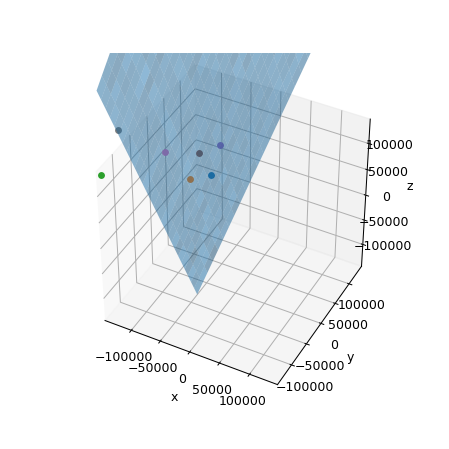

In [483]:
plot_poi(shelf_plane_norm, coordinates)

In [462]:
np.savetxt('data_for_demo_v2/shelf_plane_norm.txt', shelf_plane_norm)

In [463]:
np.savetxt('data_for_demo_v2/product_plane_coords.txt', coordinates)

In [464]:
np.savetxt('data_for_demo_v2/product_vectors.txt', z_vectors)

In [467]:
np.savetxt('data_for_demo_v2/dist_estimate.txt', np.array([DIST_ESTIMATE]))